In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.svm import SVC
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dense, Dropout, Flatten 
from tensorflow.keras.layers import Input
from tensorflow.keras import Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Utility functions

In [2]:
#
# Function for loading images based on dataset type (training/validation or testing)
#
def load_images(ds_type):
    base_path = os.path.join(os.path.join('data', 'processed_dataset'), ds_type)
    os.listdir(base_path)
    image_file_list = list(os.walk(base_path))
    random.shuffle(image_file_list)
    labels = []
    images = []
    for root, d_names, f_names in image_file_list:
        # If top level folder i.e. no files under it then go to next iteration
        if not f_names:
            continue
        # Extract label as the directory name e.g. mask, nomask etc
        label = root.split(os.path.sep)[-1]
        # loop through files and load images
        for file in f_names:
            labels.append(label)
            image = cv2.imread(os.path.join(root, file))
            images.append(image)
    return labels, images


# Create binary accuracy metric
bm = BinaryAccuracy(name='accuracy', threshold=0.5)

#
# Function for assembling and building the final model
#
def build_model(base_model, model_head):
    # Set base model layers as non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    
    # Print base model architecture
    print(f'[INFO] Base Model Summary...')
    print(base_model.summary())
    
    # Assemble the final model 
    final_model = Model(inputs=base_model.input, outputs=model_head)
    
    # Compile the model
    final_model.compile(loss='binary_crossentropy',
                        optimizer=Adam(),
                        metrics=[bm])

    # Print base model architecture
    print()
    print(f'[INFO] Final Model Summary...')
    print(final_model.summary())
    
    return final_model


#
# Function for training the model
#
def train_model(X_train, y_train, X_test, y_test, model=None, 
                train_gen=None, 
                val_gen=None,  
                batch_size=32, 
                epochs=25, 
                callbacks=[],
                verbose=0):
    # Train the model
    history = model.fit(x=training_generator.flow(X_train, y_train, 
                                                  batch_size=batch_size), 
                        epochs=epochs, 
                        steps_per_epoch=len(X_train) // batch_size,
                        validation_data=validation_generator.flow(X_test, y_test),
                        validation_steps=len(X_test) // batch_size,
                        callbacks=callbacks,
                        verbose=verbose)

    # Finally save and return the trained model with history
    #save_model(model, model_name+'.h5', save_format='h5')
    return model, history


#
# Function to plot confusion matrix
#
def show_confusion_matrix(cm, title):
    plt.figure(figsize=(10,8))
    ax = plt.subplot()
    ax.set_title(title, fontsize=20)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues", annot_kws={"size": 14}, linewidth=1, linecolor="grey") 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.xaxis.set_ticklabels(['nomask', 'mask']) 
    ax.yaxis.set_ticklabels(['nomask', 'mask'])
    plt.show();

#
# Function to plot ROC curve
#    
def show_roc_curve(svm_fpr, svm_tpr, auc_svm, title):
    plt.figure(figsize=(10, 8))
    plt.title(title, fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.plot(svm_fpr, svm_tpr, marker='.', color='orange', label=f'AUC = {auc_svm:.2f}%')
    plt.legend(fontsize=14, loc='lower right')
    plt.show();

### Load Training/Validation & Testing images with their labels

In [4]:
# Load real images
labels, images = load_images(ds_type='train_val')
# Print stats
print('Training/Validation Images...')
print('-----------------------------')
print(f'Total Labels: {len(labels)}')
print(f'Total Images: {len(images)}')
print(f'Total Masked Images: {labels.count("mask")}')
print(f'Total No-Masked Images {labels.count("nomask")}')
# Convert data into numpy arrays
labels, images = np.array(labels), np.array(images)
      
# Load test images
s_labels, s_images = load_images(ds_type='test')   
# Print stats
print()
print('Testing Images...')
print('------------------------------')
print(f'Total Labels: {len(s_labels)}')
print(f'Total Images: {len(s_images)}')
print(f'Total Masked Images: {s_labels.count("mask")}')
print(f'Total No-Masked Images {s_labels.count("nomask")}')
# Convert data into numpy arrays
s_labels, s_images = np.array(s_labels), np.array(s_images)      
eval_data = {'labels':s_labels, 'images':s_images}

Training/Validation Images...
-----------------------------
Total Labels: 10414
Total Images: 10414
Total Masked Images: 5207
Total No-Masked Images 5207

Testing Images...
------------------------------
Total Labels: 1000
Total Images: 1000
Total Masked Images: 500
Total No-Masked Images 500


### Split training data (real images) into 75% training and 25% testing set

In [5]:
# One-hot encode the labels for real images
lb1 = LabelBinarizer()
r_labels = lb1.fit_transform(labels)
train_class_labels = lb1.classes_

# Split the data for real images (used for training)
X_train, X_val, y_train, y_val = train_test_split(images, 
                                                  r_labels, 
                                                  test_size=0.20, 
                                                  random_state=42)

# One-hot encode the labels for simulated images
X_test = eval_data['images']
# One-hot encode the labels
lb2 = LabelBinarizer()
y_test = lb2.fit_transform(eval_data['labels'])
#y_test = to_categorical(y_test_bin)
test_class_labels = lb2.classes_

In [6]:
print(f'X_train: {X_train.shape}\ny_train: {y_train.shape}\n\nX_val: {X_val.shape}\ny_val: {y_val.shape}\n')
print(f'X_test: {X_test.shape}\ny_test: {y_test.shape}')

X_train: (8331, 224, 224, 3)
y_train: (8331, 1)

X_val: (2083, 224, 224, 3)
y_val: (2083, 1)

X_test: (1000, 224, 224, 3)
y_test: (1000, 1)


### Create data generator

In [7]:
# Training data generator with image augumentation
training_generator = ImageDataGenerator(rotation_range=20,
                                        zoom_range=0.15,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.15,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

# Validation data generator without any image augumentation
validation_generator = ImageDataGenerator()

### Build models using transfer learning

In [8]:
# Create the base ResNet50 model without the top layer
resnet50_base = ResNet50(weights='imagenet', 
                         include_top=False, 
                         input_tensor=Input(shape=(224, 224, 3)))

94773248/94765736 [==============================] - 2s 0us/step


In [9]:
# Create the base MobileNetV2 model without the top layer
mobilenetv2_base = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


#### 1. Create RestNet50 model with SVM binary classifier

In [12]:
# Build feature extractor CNN
fe_layer = resnet50_base.output
fe_layer = MaxPooling2D() (fe_layer)
fe_layer = Flatten() (fe_layer)
fe_layer = Dense(512, activation='relu') (fe_layer)
resnet50_fe_model = build_model(resnet50_base, fe_layer)

[INFO] Base Model Summary...
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________

In [13]:
# Extract features for training
%time train_features = resnet50_fe_model.predict(X_train)

CPU times: user 57.1 s, sys: 1.06 s, total: 58.2 s
Wall time: 1min 7s


In [14]:
# Extract features for validation
%time val_features = resnet50_fe_model.predict(X_val)

CPU times: user 14.1 s, sys: 139 ms, total: 14.2 s
Wall time: 14.2 s


In [15]:
# Extract features for testing on unseen simulated images
%time test_features = resnet50_fe_model.predict(X_test)

CPU times: user 6.97 s, sys: 53.3 ms, total: 7.03 s
Wall time: 7.05 s


In [16]:
# Train SVM
svm = SVC(kernel='rbf', gamma='auto', probability=True, random_state=42)
%time svm.fit(train_features, y_train.ravel())

CPU times: user 1min 33s, sys: 36 ms, total: 1min 33s
Wall time: 1min 33s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
# Predict using training (real) images
%time train_preds = svm.predict(train_features)

CPU times: user 15.6 s, sys: 0 ns, total: 15.6 s
Wall time: 15.6 s


In [48]:
# Predict using validation (real) images
%time val_preds = svm.predict(val_features)

CPU times: user 3.92 s, sys: 0 ns, total: 3.92 s
Wall time: 3.91 s


In [18]:
# Predict using unseen evaluation (simulated) images
%time test_preds = svm.predict(test_features)

CPU times: user 1.91 s, sys: 0 ns, total: 1.91 s
Wall time: 1.91 s


In [19]:
# Evaluate prediction and print results
print()
print('ResNet50 with SVM classifier' + ' - ' + 'Performance')
print('------------------------------------------')
print(f'Training Accuracy: {accuracy_score(y_train, train_preds)*100:.2f}%')
print(f'Validation Accuracy: {accuracy_score(y_val, val_preds)*100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, test_preds)*100:.2f}%')
print()
print('Test - Classification Report')
print(classification_report(y_test, test_preds))


ResNet50 with SVM classifier - Performance
------------------------------------------
Training Accuracy: 99.92%
Validation Accuracy: 97.17%
Test Accuracy: 97.50%

Test - Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       500
           1       0.99      0.96      0.97       500

   micro avg       0.97      0.97      0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000



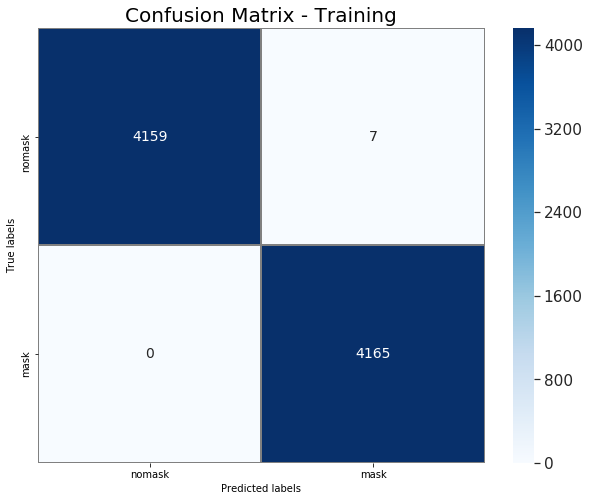

In [20]:
# Plot confusion matrix - training
cm = confusion_matrix(y_train, train_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Training')

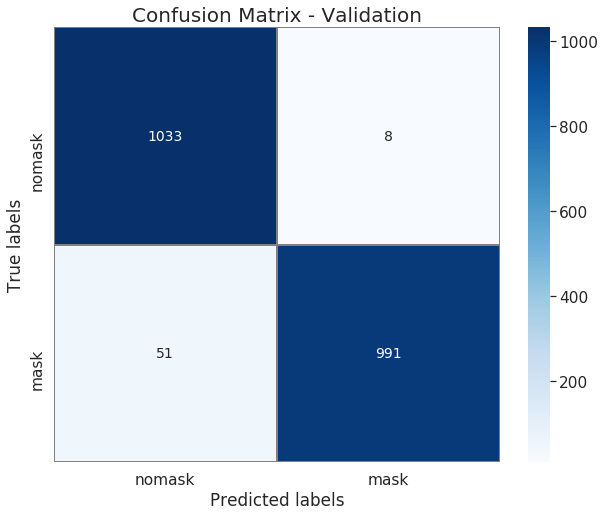

In [21]:
# Plot confusion matrix - validation
cm = confusion_matrix(y_val, val_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Validation')

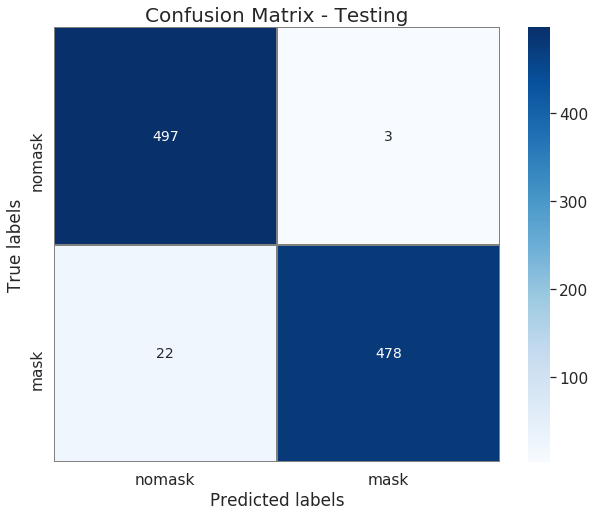

In [22]:
# Plot confusion matrix - test
cm = confusion_matrix(y_test, test_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Testing')

CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 15.8 s


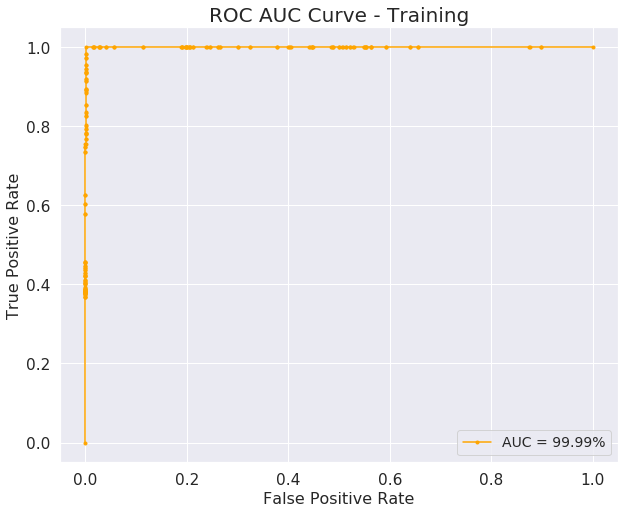

In [23]:
# Predict probability of positive class (nomask) using training (real) images
%time train_preds_proba = svm.predict_proba(train_features)[:,1]
# Plot ROC AUC Curve - Training
svm_fpr, svm_tpr, threshold = roc_curve(y_train, train_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Training')

CPU times: user 3.96 s, sys: 0 ns, total: 3.96 s
Wall time: 3.96 s


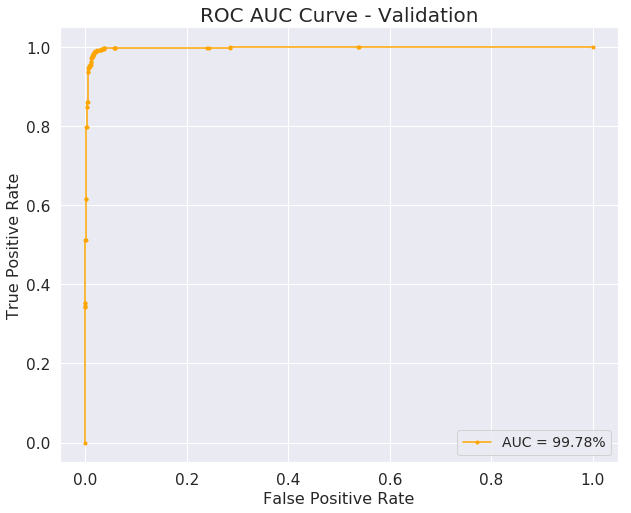

In [24]:
# Predict probability of positive class (nomask) using validation (real) images
%time val_preds_proba = svm.predict_proba(val_features)[:,1]
# Plot ROC AUC Curve - Validation
svm_fpr, svm_tpr, threshold = roc_curve(y_val, val_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Validation')

CPU times: user 1.9 s, sys: 3.5 ms, total: 1.91 s
Wall time: 1.91 s


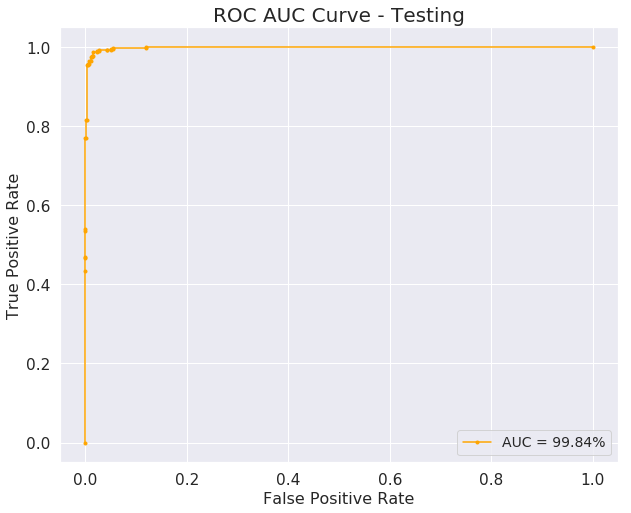

In [25]:
# Predict probability of positive class (nomask) using testing (real) images
%time test_preds_proba = svm.predict_proba(test_features)[:,1]
# Plot ROC AUC Curve - Testing
svm_fpr, svm_tpr, threshold = roc_curve(y_test, test_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Testing')

#### 2. Create RestNet50 model with Fully connected binary classifier

In [26]:
# Create a fully connected binary layer as last layer of the model
fc_layer = resnet50_base.output
fc_layer = MaxPooling2D(pool_size=(2, 2), strides = (3,3)) (fc_layer) 
fc_layer = Flatten() (fc_layer)
fc_layer = Dense(512, activation='relu') (fc_layer)
fc_layer = Dropout(0.25) (fc_layer)
fc_layer = Dense(1, activation='sigmoid') (fc_layer)

# Build the model
resnet50_fc_model = build_model(resnet50_base, fc_layer)

[INFO] Base Model Summary...
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________

In [27]:
# Use early-stopping to prevent overfitting 
early_stopping = EarlyStopping(monitor='val_loss', 
                               verbose = 1, 
                               patience=10, 
                               min_delta = .00075)

# Saves model every time the validation loss improves, finally we only have best model saved
model_checkpoint = ModelCheckpoint('ResNet50_FC.h5', 
                                   verbose = 1, 
                                   save_best_only=True,
                                   monitor = 'val_loss')
# Adjust learning rate on plateau
lr_plat = ReduceLROnPlateau(patience = 2, 
                            mode = 'min')

In [31]:
%%time
# Train the model
resnet50_fc_model, history = train_model(X_train, y_train, X_val, y_val,
                                         model=resnet50_fc_model,
                                         train_gen=training_generator, 
                                         val_gen=validation_generator,
                                         batch_size=32,
                                         epochs=100,
                                         callbacks = [early_stopping, model_checkpoint, lr_plat], 
                                         verbose= 1)    

Epoch 1/100
260/260 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9743
Epoch 00001: val_loss improved from inf to 0.04479, saving model to ResNet50_FC.h5
260/260 [==============================] - 111s 428ms/step - loss: 0.2153 - accuracy: 0.9743 - val_loss: 0.0448 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 2/100
260/260 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9852
Epoch 00002: val_loss improved from 0.04479 to 0.03174, saving model to ResNet50_FC.h5
260/260 [==============================] - 111s 429ms/step - loss: 0.0619 - accuracy: 0.9852 - val_loss: 0.0317 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 3/100
260/260 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9861
Epoch 00003: val_loss improved from 0.03174 to 0.02660, saving model to ResNet50_FC.h5
260/260 [==============================] - 112s 430ms/step - loss: 0.0482 - accuracy: 0.9861 - val_loss: 0.0266 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/

In [75]:
from tensorflow.keras.models import load_model
saved_model = load_model('ResNet50_FC.h5')

In [76]:
# Predict using training (real) images
%time train_preds_proba = saved_model.predict(X_train)
train_preds = np.where(train_preds_proba > 0.5, 1, 0)

CPU times: user 54.8 s, sys: 637 ms, total: 55.5 s
Wall time: 54.7 s


In [77]:
# Predict using validation (real) images
%time val_preds_proba = saved_model.predict(X_val)
val_preds = np.where(val_preds_proba > 0.5, 1, 0)

CPU times: user 13.5 s, sys: 213 ms, total: 13.7 s
Wall time: 13.6 s


In [78]:
# Predict using unseen evaluation (simulated) images
%time test_preds_proba = saved_model.predict(X_test)
test_preds = np.where(test_preds_proba > 0.5, 1, 0)

CPU times: user 6.4 s, sys: 5.49 ms, total: 6.4 s
Wall time: 6.45 s


In [79]:
# Evaluate prediction and print results
print()
print('ResNet50 with FC classifier' + ' - ' + 'Performance')
print('------------------------------------------')
print()
print(f'Training Accuracy: {accuracy_score(y_train, train_preds)*100:.2f}%')
print(f'Validation Accuracy: {accuracy_score(y_val, val_preds)*100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, test_preds)*100:.2f}%')
print()
print('Test - Classification Report')
print(classification_report(y_test, test_preds))


ResNet50 with FC classifier - Performance
------------------------------------------

Training Accuracy: 99.80%
Validation Accuracy: 99.47%
Test Accuracy: 99.60%

Test - Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       500
           1       0.99      1.00      1.00       500

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



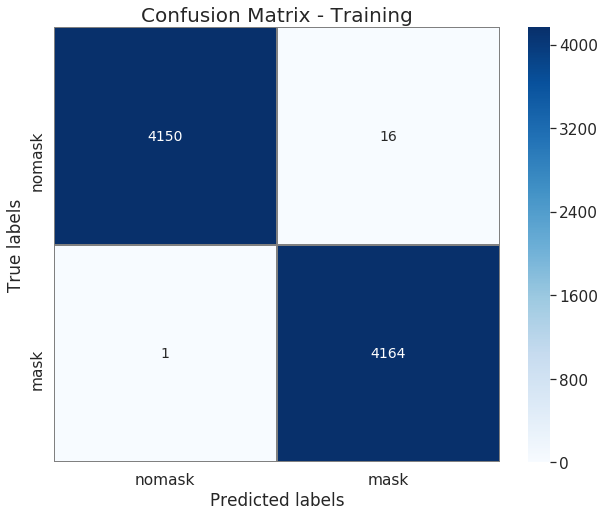

In [80]:
# Plot confusion matrix - training
cm = confusion_matrix(y_train, train_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Training')

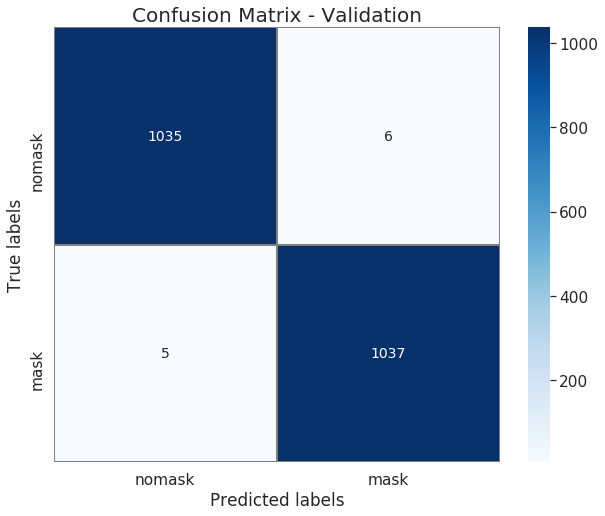

In [81]:
# Plot confusion matrix - Validation
cm = confusion_matrix(y_val, val_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Validation')

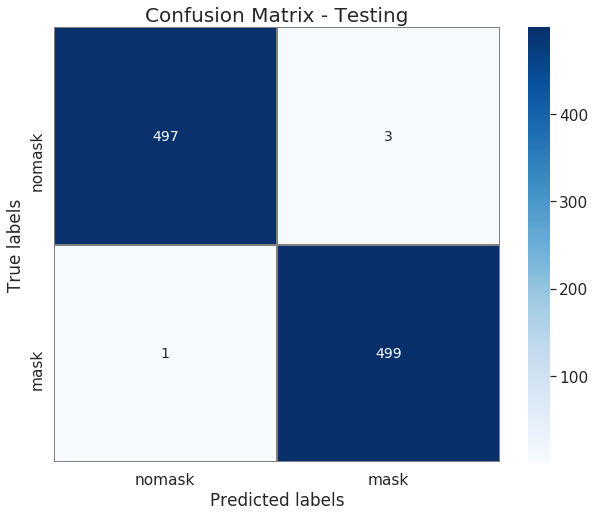

In [82]:
# Plot confusion matrix - Testing
cm = confusion_matrix(y_test, test_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Testing')

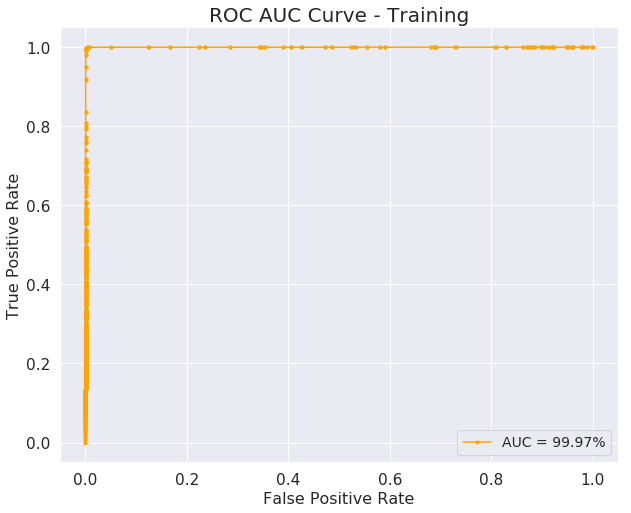

In [83]:
# Plot ROC AUC Curve - Training
fc_fpr, fc_tpr, threshold = roc_curve(y_train, train_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Training')

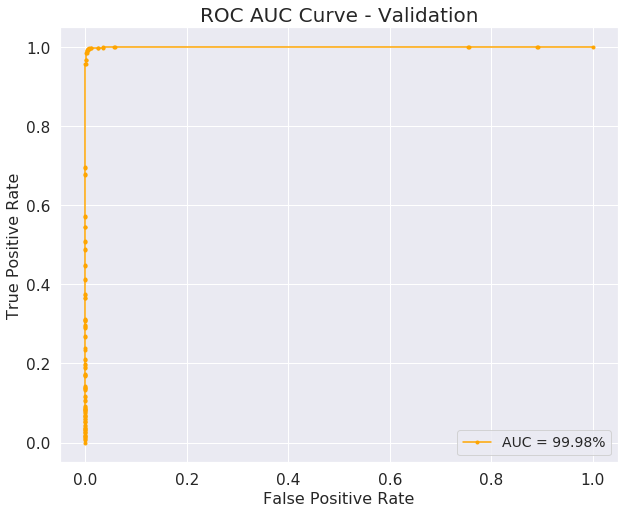

In [84]:
# Plot ROC AUC Curve - Validation
fc_fpr, fc_tpr, threshold = roc_curve(y_val, val_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Validation')

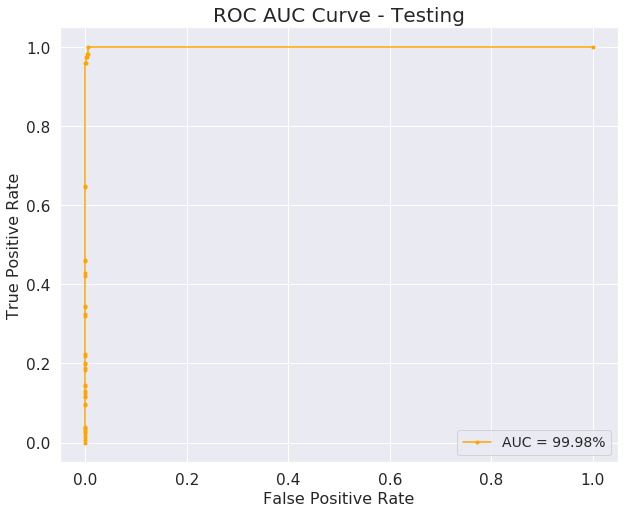

In [85]:
# Plot ROC AUC Curve - Testing
fc_fpr, fc_tpr, threshold = roc_curve(y_test, test_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Testing')

#### 3. Create MobileNetV2 based feature-extractor CNN model with SVM classifier

In [49]:
# Build feature extractor CNN using MobileNetV2
fe_layer = mobilenetv2_base.output
fe_layer = MaxPooling2D() (fe_layer)
fe_layer = Flatten() (fe_layer)
fe_layer = Dense(512, activation='relu') (fe_layer)
mobilenetv2_fe_model = build_model(mobilenetv2_base, fe_layer)

[INFO] Base Model Summary...
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________

In [60]:
# Extract features for training
%time train_features = mobilenetv2_fe_model.predict(X_train)

CPU times: user 19.9 s, sys: 443 ms, total: 20.4 s
Wall time: 19.5 s


In [61]:
# Extract features for validation
%time val_features = mobilenetv2_fe_model.predict(X_val)

CPU times: user 4.83 s, sys: 148 ms, total: 4.98 s
Wall time: 4.81 s


In [62]:
# Extract features for testing
%time test_features = mobilenetv2_fe_model.predict(X_test)

CPU times: user 2.27 s, sys: 17.1 ms, total: 2.28 s
Wall time: 2.23 s


In [64]:
# Train SVM
svm = SVC(kernel='rbf', gamma='auto', probability=True, random_state=42)
%time svm.fit(train_features, y_train.ravel())

CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 2s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
# Predict using training (real) images
%time train_preds = svm.predict(train_features)

CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 10.5 s


In [66]:
# Predict using validation (real) images
%time val_preds = svm.predict(val_features)

CPU times: user 2.64 s, sys: 0 ns, total: 2.64 s
Wall time: 2.63 s


In [67]:
# Predict using unseen evaluation (simulated) images
%time test_preds = svm.predict(test_features)

CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.26 s


In [68]:
# Evaluate prediction and print results
print()
print('MobileNetV2 with SVM classifier' + ' - ' + 'Performance')
print('------------------------------------------')
print(f'Training Accuracy: {accuracy_score(y_train, train_preds)*100:.2f}%')
print(f'Validation Accuracy: {accuracy_score(y_val, val_preds)*100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, test_preds)*100:.2f}%')
print()
print('Test - Classification Report')
print(classification_report(y_test, test_preds))


MobileNetV2 with SVM classifier - Performance
------------------------------------------
Training Accuracy: 98.46%
Validation Accuracy: 96.35%
Test Accuracy: 95.90%

Test - Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       500
           1       0.94      0.98      0.96       500

   micro avg       0.96      0.96      0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



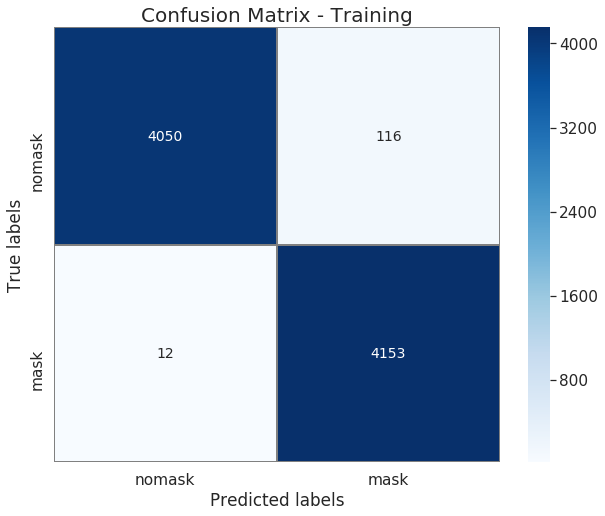

In [69]:
# Plot confusion matrix - training
cm = confusion_matrix(y_train, train_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Training')

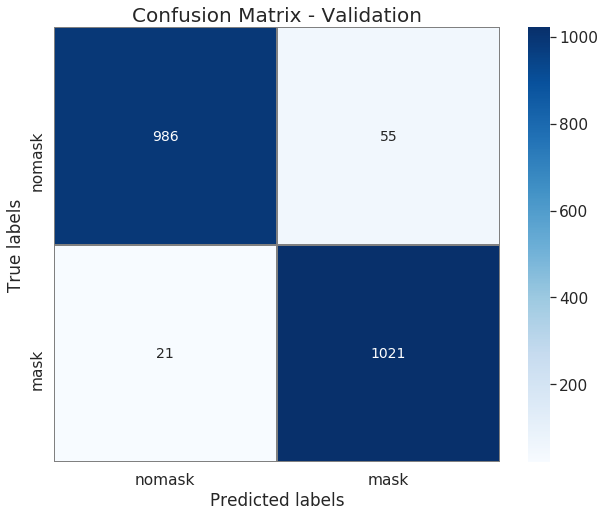

In [70]:
# Plot confusion matrix - validation
cm = confusion_matrix(y_val, val_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Validation')

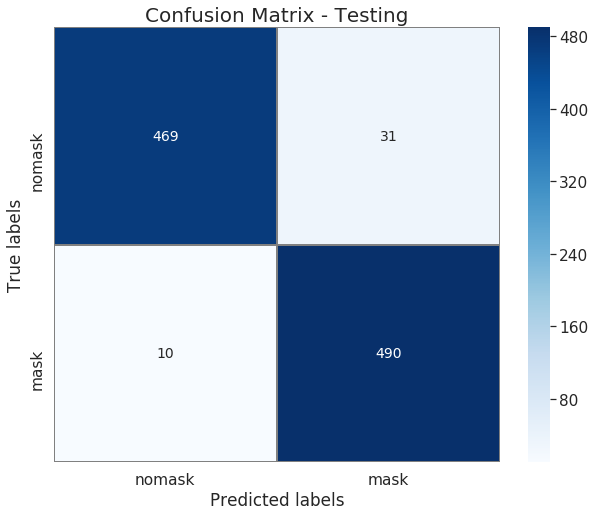

In [71]:
# Plot confusion matrix - test
cm = confusion_matrix(y_test, test_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Testing')

CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 10.5 s


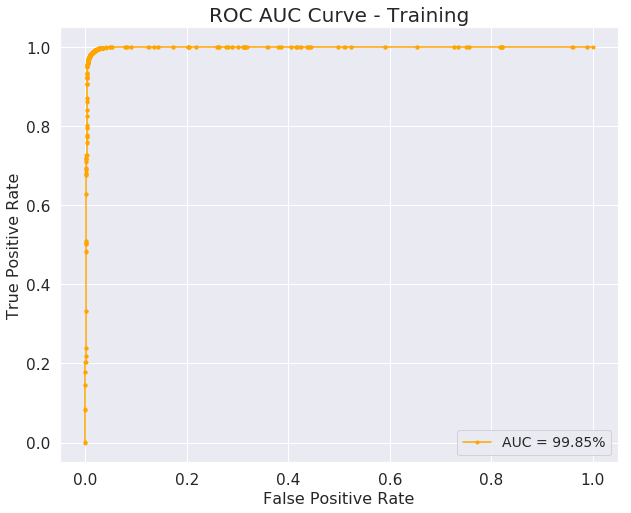

In [72]:
# Predict probability of positive class (nomask) using training (real) images
%time train_preds_proba = svm.predict_proba(train_features)[:,1]
# Plot ROC AUC Curve - Training
svm_fpr, svm_tpr, threshold = roc_curve(y_train, train_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Training')

CPU times: user 2.68 s, sys: 21 ms, total: 2.7 s
Wall time: 2.65 s


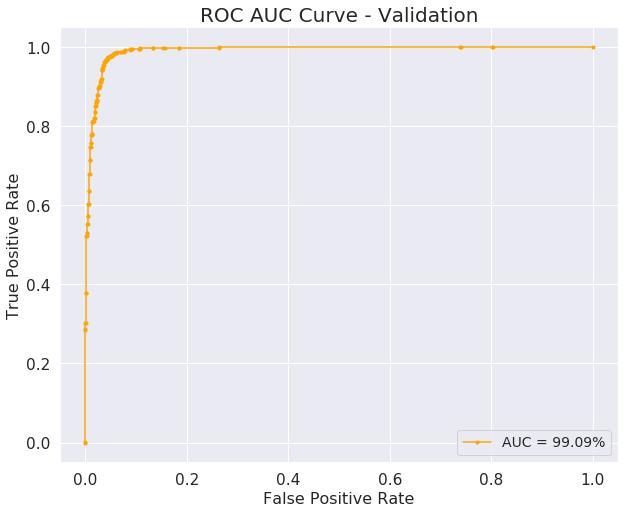

In [73]:
# Predict probability of positive class (nomask) using validation (real) images
%time val_preds_proba = svm.predict_proba(val_features)[:,1]
# Plot ROC AUC Curve - Validation
svm_fpr, svm_tpr, threshold = roc_curve(y_val, val_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Validation')

CPU times: user 1.29 s, sys: 27.3 ms, total: 1.32 s
Wall time: 1.28 s


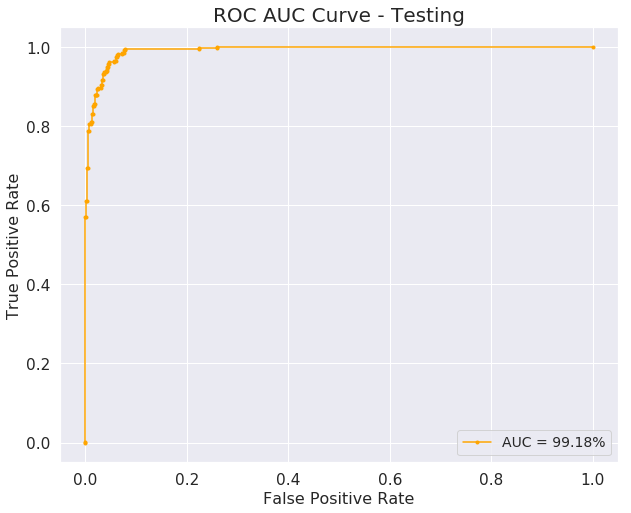

In [74]:
# Predict probability of positive class (nomask) using testing (real) images
%time test_preds_proba = svm.predict_proba(test_features)[:,1]
# Plot ROC AUC Curve - Testing
svm_fpr, svm_tpr, threshold = roc_curve(y_test, test_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Testing')

#### 4. Create MobileNetV2 based feature-extractor CNN model with fully connected binary classifier

In [10]:
# Create a fully connected binary layer as last layer of the model
fc_layer = mobilenetv2_base.output
fc_layer = MaxPooling2D(pool_size=(2, 2), strides = (3,3)) (fc_layer) 
fc_layer = Flatten() (fc_layer)
fc_layer = Dense(512, activation='relu') (fc_layer)
fc_layer = Dropout(0.25) (fc_layer)
fc_layer = Dense(1, activation='sigmoid') (fc_layer)
# Build the model
mobilenetv2_fc_model = build_model(mobilenetv2_base, fc_layer)

[INFO] Base Model Summary...
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________

In [11]:
# Use early-stopping to prevent overfitting 
early_stopping = EarlyStopping(monitor='val_loss', 
                               verbose = 1, 
                               patience=10, 
                               min_delta = .00075)

# Saves model every time the validation loss improves, finally we only have best model saved
model_checkpoint = ModelCheckpoint('MobileNetV2_FC.h5', 
                                   verbose = 1, 
                                   save_best_only=True,
                                   monitor = 'val_loss')
# Adjust learning rate on plateau
lr_plat = ReduceLROnPlateau(patience = 2, 
                            mode = 'min')

In [12]:
%%time
# Train the model
mobilenetv2_fc_model, history = train_model(X_train, y_train, X_val, y_val,
                                         model=mobilenetv2_fc_model,
                                         train_gen=training_generator, 
                                         val_gen=validation_generator,
                                         batch_size=32,
                                         epochs=100,
                                         callbacks = [early_stopping, model_checkpoint, lr_plat], 
                                         verbose= 1)    

Epoch 1/100
260/260 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8993
Epoch 00001: val_loss improved from inf to 0.12306, saving model to MobileNetV2_FC.h5
260/260 [==============================] - 99s 380ms/step - loss: 0.3352 - accuracy: 0.8993 - val_loss: 0.1231 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 2/100
260/260 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9310
Epoch 00002: val_loss improved from 0.12306 to 0.10757, saving model to MobileNetV2_FC.h5
260/260 [==============================] - 96s 368ms/step - loss: 0.1817 - accuracy: 0.9310 - val_loss: 0.1076 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 3/100
260/260 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9361
Epoch 00003: val_loss improved from 0.10757 to 0.10313, saving model to MobileNetV2_FC.h5
260/260 [==============================] - 95s 364ms/step - loss: 0.1653 - accuracy: 0.9361 - val_loss: 0.1031 - val_accuracy: 0.9668 - lr: 0.0010
Ep

In [13]:
from tensorflow.keras.models import load_model
saved_model = load_model('MobileNetV2_FC.h5')

In [14]:
# Predict using training (real) images
%time train_preds_proba = saved_model.predict(X_train)
train_preds = np.where(train_preds_proba > 0.5, 1, 0)

CPU times: user 21 s, sys: 700 ms, total: 21.7 s
Wall time: 21.1 s


In [15]:
# Predict using validation (real) images
%time val_preds_proba = saved_model.predict(X_val)
val_preds = np.where(val_preds_proba > 0.5, 1, 0)

CPU times: user 5.24 s, sys: 71 ms, total: 5.31 s
Wall time: 5.16 s


In [18]:
# Predict using unseen evaluation (simulated) images
%time test_preds_proba = saved_model.predict(X_test)
test_preds = np.where(test_preds_proba > 0.5, 1, 0)

CPU times: user 2.45 s, sys: 101 ms, total: 2.55 s
Wall time: 2.49 s


In [17]:
# Evaluate prediction and print results
print()
print('MobileNetV2 with FC classifier' + ' - ' + 'Performance')
print('------------------------------------------')
print(f'Training Accuracy: {accuracy_score(y_train, train_preds)*100:.2f}%')
print(f'Validation Accuracy: {accuracy_score(y_val, val_preds)*100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, test_preds)*100:.2f}%')
print()
print('Test - Classification Report')
print(classification_report(y_test, test_preds))


MobileNetV2 with FC classifier - Performance
------------------------------------------
Training Accuracy: 97.42%
Validation Accuracy: 97.17%
Test Accuracy: 96.60%

Test - Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       500
           1       0.96      0.98      0.97       500

   micro avg       0.97      0.97      0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



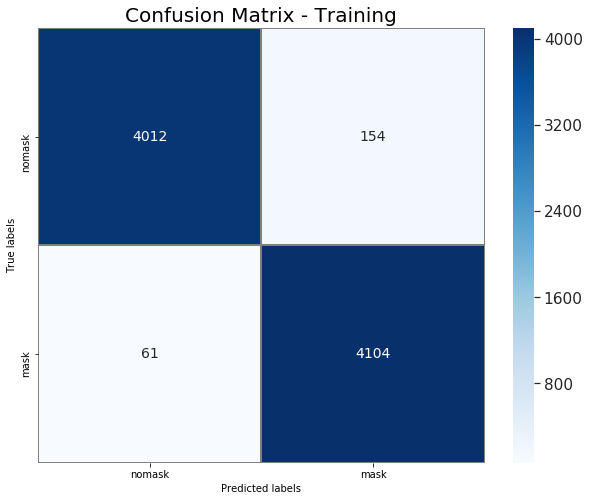

In [19]:
# Plot confusion matrix - training
cm = confusion_matrix(y_train, train_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Training')

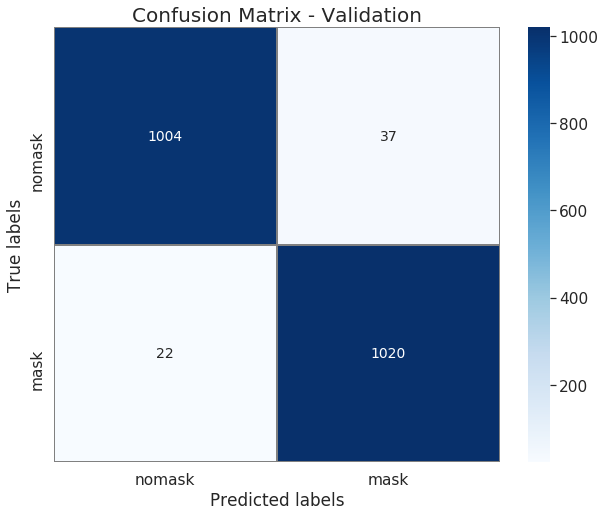

In [20]:
# Plot confusion matrix - Validation
cm = confusion_matrix(y_val, val_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Validation')

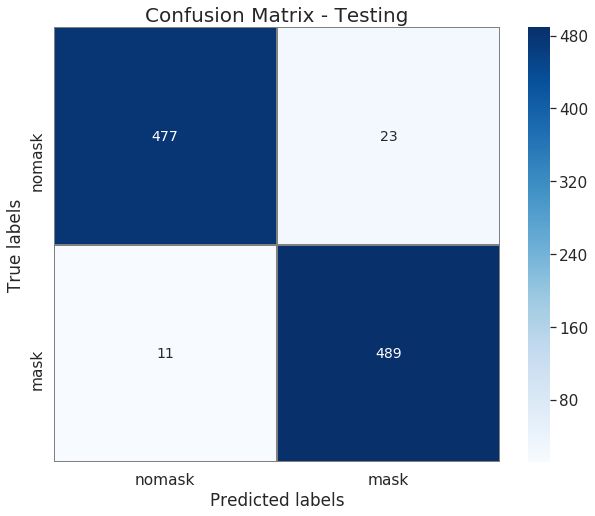

In [21]:
# Plot confusion matrix - Testing
cm = confusion_matrix(y_test, test_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Testing')

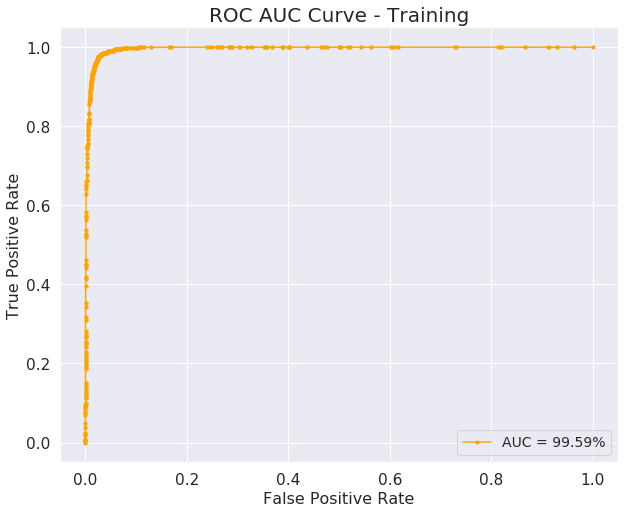

In [22]:
# Plot ROC AUC Curve - Training
fc_fpr, fc_tpr, threshold = roc_curve(y_train, train_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Training')

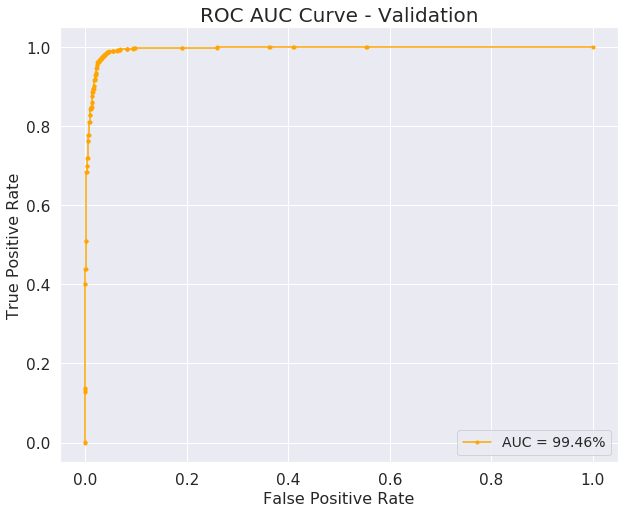

In [23]:
# Plot ROC AUC Curve - Validation
fc_fpr, fc_tpr, threshold = roc_curve(y_val, val_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Validation')

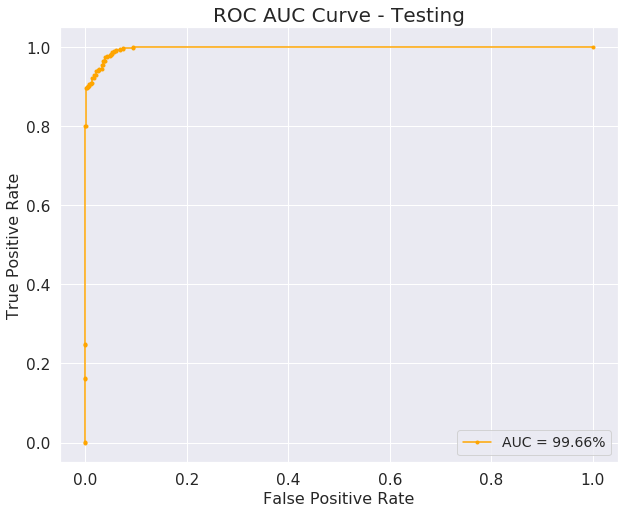

In [24]:
# Plot ROC AUC Curve - Testing
fc_fpr, fc_tpr, threshold = roc_curve(y_test, test_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Testing')

#### 5. Create custom CNN model with Fully connected binary classifier

In [8]:
model = Sequential()
model.add(Conv2D(512, kernel_size=(3,3), input_shape = (224,224,3), kernel_regularizer = regularizers.l1(.001), name='Input'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))

model.add(Conv2D(256, kernel_size=(3,3), kernel_regularizer = regularizers.l1(.001)))
model.add(BatchNormalization())
model.add(Activation('relu', name='Conv2D_256'))
model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))

model.add(Conv2D(128, (3, 3), kernel_regularizer = regularizers.l1(.001)))
model.add(BatchNormalization())
model.add(Activation('relu', name='Conv2D_128'))
model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))

model.add(Conv2D(64, (3, 3), kernel_regularizer = regularizers.l1(.001)))
model.add(BatchNormalization())
model.add(Activation('relu', name='Conv2D_64'))

model.add(Conv2D(32, (3, 3), kernel_regularizer = regularizers.l1(.001)))
model.add(BatchNormalization())
model.add(Activation('relu', name='Conv2D_32'))

model.add(Flatten(name='Flatten'))
model.add(Dense(512))
model.add(Activation('relu', name='Dense_512'))

model.add(Dense(256))
model.add(Activation('relu', name='Dense_256'))

model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid', name='output'))
model.summary()
custom_cnn_fc_model = model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Conv2D)               (None, 222, 222, 512)     14336     
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 512)     2048      
_________________________________________________________________
activation (Activation)      (None, 222, 222, 512)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 72, 72, 256)       1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 256)       1024      
_________________________________________________________________
Conv2D_256 (Activation)      (None, 72, 72, 256)       0

In [ ]:
# Compile the model
custom_cnn_fc_model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.0001),
              metrics = [bm])

In [11]:
# Load saved model
custom_cnn_fc_model = load_model('custom_FC.h5')

# Use early-stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               verbose = 1,
                               patience=10,
                               min_delta = .00075)

# Saves model every time the validation loss improves, finally we only have best model saved
model_checkpoint = ModelCheckpoint('custom_FC.h5',
                                   verbose = 1,
                                   save_best_only=True,
                                   monitor = 'val_loss')
# Adjust learning rate on plateau
lr_plat = ReduceLROnPlateau(patience = 2,
                            mode = 'min')

In [12]:
# Train the model with above callbacks
custom_cnn_fc_model, history = train_model(X_train, y_train, X_val, y_val,
                                         model=custom_cnn_fc_model,
                                         train_gen=training_generator, 
                                         val_gen=validation_generator,
                                         batch_size=24,
                                         epochs=100,
                                         callbacks = [early_stopping, model_checkpoint, lr_plat], 
                                         verbose= 1)    

Epoch 1/100
347/347 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.9803
Epoch 00001: val_loss improved from inf to 0.27913, saving model to custom_FC.h5
347/347 [==============================] - 266s 768ms/step - loss: 0.3042 - accuracy: 0.9803 - val_loss: 0.2791 - val_accuracy: 0.9912 - lr: 1.0000e-06
Epoch 2/100
347/347 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.9782
Epoch 00002: val_loss did not improve from 0.27913
347/347 [==============================] - 266s 765ms/step - loss: 0.3079 - accuracy: 0.9782 - val_loss: 0.2810 - val_accuracy: 0.9901 - lr: 1.0000e-06
Epoch 3/100
347/347 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.9794
Epoch 00003: val_loss did not improve from 0.27913
347/347 [==============================] - 263s 759ms/step - loss: 0.3072 - accuracy: 0.9794 - val_loss: 0.2796 - val_accuracy: 0.9901 - lr: 1.0000e-06
Epoch 4/100
347/347 [==============================] - ETA: 0s - loss:

In [3]:
# Load saved model
saved_model = load_model('custom_FC.h5')

In [26]:
# Predict using training (real) images
%time train_preds_proba = saved_model.predict(X_train)
train_preds = np.where(train_preds_proba > 0.5, 1, 0)

CPU times: user 1min 22s, sys: 636 ms, total: 1min 23s
Wall time: 1min 22s


In [27]:
# Predict using validation (real) images
%time val_preds_proba = saved_model.predict(X_val)
val_preds = np.where(val_preds_proba > 0.5, 1, 0)

CPU times: user 20.2 s, sys: 13.2 ms, total: 20.2 s
Wall time: 20.3 s


In [28]:
# Predict using unseen evaluation (simulated) images
%time test_preds_proba = saved_model.predict(X_test)
test_preds = np.where(test_preds_proba > 0.5, 1, 0)

CPU times: user 10.1 s, sys: 97.4 ms, total: 10.2 s
Wall time: 10.4 s


In [29]:
# Evaluate prediction and print results
print()
print('Custom CNN with FC classifier' + ' - ' + 'Performance')
print('------------------------------------------')
print(f'Training Accuracy: {accuracy_score(y_train, train_preds)*100:.2f}%')
print(f'Validation Accuracy: {accuracy_score(y_val, val_preds)*100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, test_preds)*100:.2f}%')
print()
print('Test - Classification Report')
print(classification_report(y_test, test_preds))


Custom CNN with FC classifier - Performance
------------------------------------------
Training Accuracy: 99.00%
Validation Accuracy: 99.14%
Test Accuracy: 98.60%

Test - Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       500
           1       0.98      0.99      0.99       500

   micro avg       0.99      0.99      0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



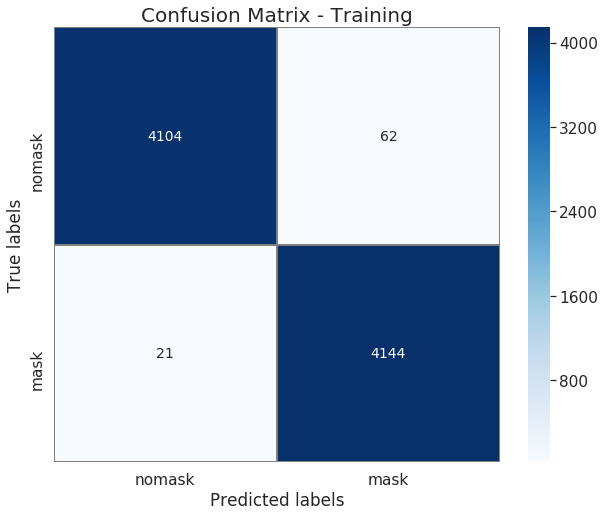

In [30]:
# Plot confusion matrix - training
cm = confusion_matrix(y_train, train_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Training')

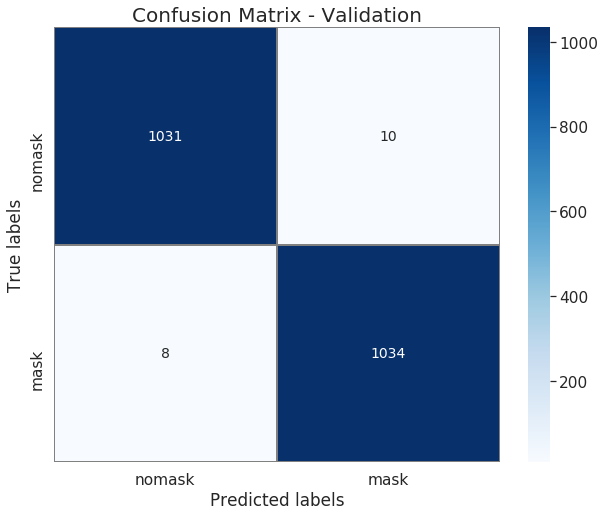

In [31]:
# Plot confusion matrix - Validation
cm = confusion_matrix(y_val, val_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Validation')

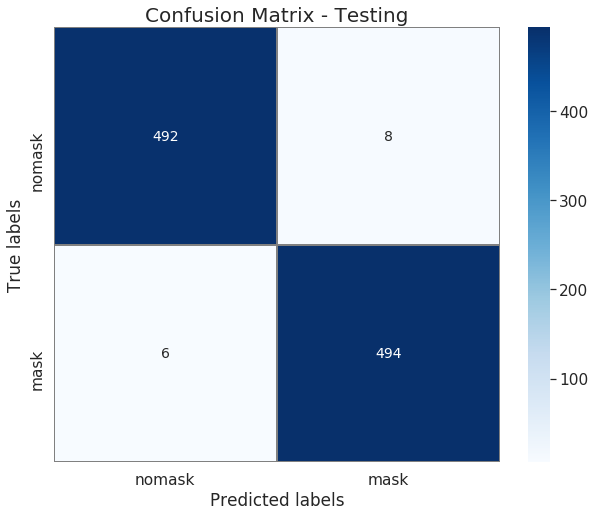

In [32]:
# Plot confusion matrix - Testing
cm = confusion_matrix(y_test, test_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Testing')

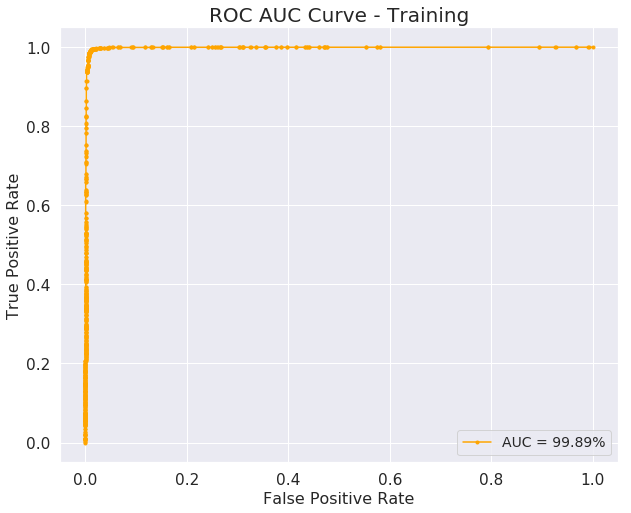

In [33]:
# Plot ROC AUC Curve - Training
fc_fpr, fc_tpr, threshold = roc_curve(y_train, train_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Training')

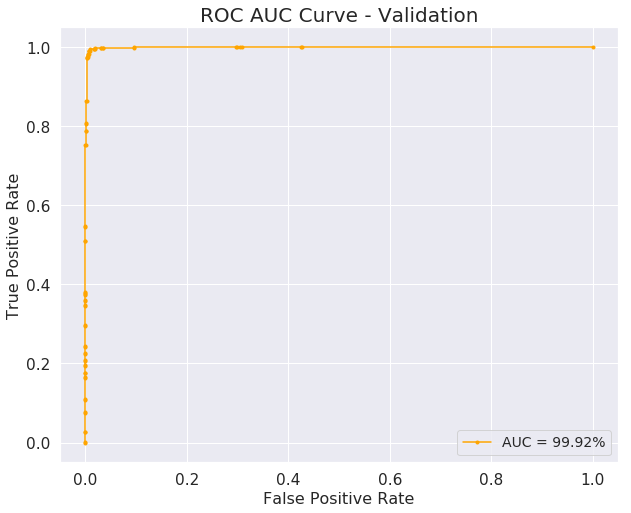

In [34]:
# Plot ROC AUC Curve - Validation
fc_fpr, fc_tpr, threshold = roc_curve(y_val, val_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Validation')

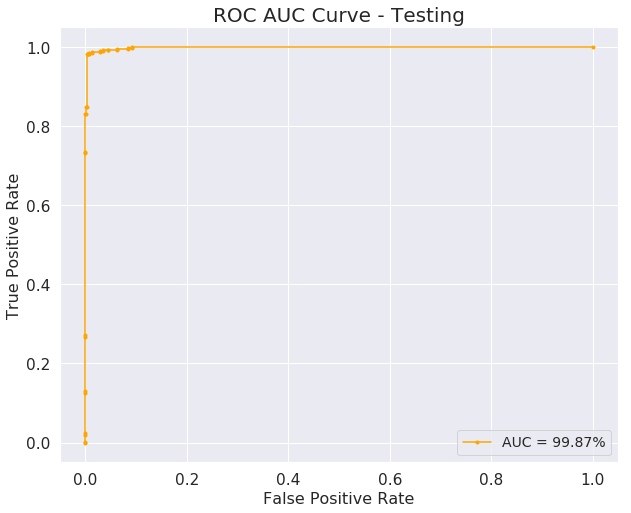

In [35]:
# Plot ROC AUC Curve - Testing
fc_fpr, fc_tpr, threshold = roc_curve(y_test, test_preds_proba)
auc_fc = auc(fc_fpr, fc_tpr)*100
show_roc_curve(fc_fpr, fc_tpr, auc_fc, 'ROC AUC Curve - Testing')

#### 6. Create custom CNN model with SVM classifier

In [5]:
# Load saved custom model
saved_model = load_model('custom_FC.h5')
# Get the base model without the classifier FC layer 
inputs = saved_model.inputs
outputs = saved_model.get_layer('Dense_512').output
# Create feature extractor
fe_model = Model(inputs=inputs, outputs=outputs)

In [6]:
fe_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Input (Conv2D)               (None, 222, 222, 512)     14336     
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 512)     2048      
_________________________________________________________________
activation (Activation)      (None, 222, 222, 512)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 72, 72, 256)       1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 256)       1024  

In [22]:
# Extract features for training
%time train_features = fe_model.predict(X_train)

CPU times: user 1min 21s, sys: 979 ms, total: 1min 22s
Wall time: 1min 34s


In [23]:
# Extract features for validation
%time val_features = fe_model.predict(X_val)

CPU times: user 19.8 s, sys: 104 ms, total: 19.9 s
Wall time: 20 s


In [24]:
# Extract features for testing
%time test_features = fe_model.predict(X_test)

CPU times: user 9.86 s, sys: 20 ms, total: 9.88 s
Wall time: 10 s


In [25]:
# Bulild SVM classifier and train on train feature extracted above
svm = SVC(kernel='rbf', gamma='auto', probability=True, random_state=42)
%time svm.fit(train_features, y_train.ravel())

CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Predict using training (real) images
%time train_preds = svm.predict(train_features)

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.85 s


In [27]:
# Predict using validation (real) images
%time val_preds = svm.predict(val_features)

CPU times: user 466 ms, sys: 0 ns, total: 466 ms
Wall time: 464 ms


In [28]:
# Predict using unseen evaluation (simulated) images
%time test_preds = svm.predict(test_features)

CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 224 ms


In [29]:
# Evaluate prediction and print results
print()
print('Custom CNN with SVM classifier' + ' - ' + 'Performance')
print('------------------------------------------')
print(f'Training Accuracy: {accuracy_score(y_train, train_preds)*100:.2f}%')
print(f'Validation Accuracy: {accuracy_score(y_val, val_preds)*100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, test_preds)*100:.2f}%')
print()
print('Test - Classification Report')
print(classification_report(y_test, test_preds))


Custom CNN with SVM classifier - Performance
------------------------------------------
Training Accuracy: 99.17%
Validation Accuracy: 99.18%
Test Accuracy: 98.40%

Test - Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       500
           1       0.98      0.99      0.98       500

   micro avg       0.98      0.98      0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



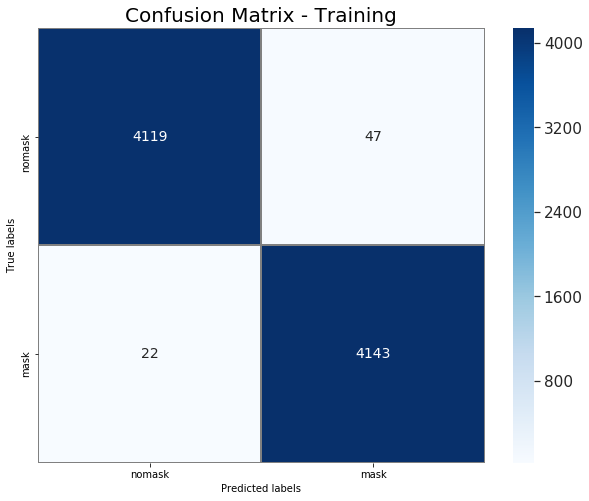

In [30]:
# Plot confusion matrix - training
cm = confusion_matrix(y_train, train_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Training')

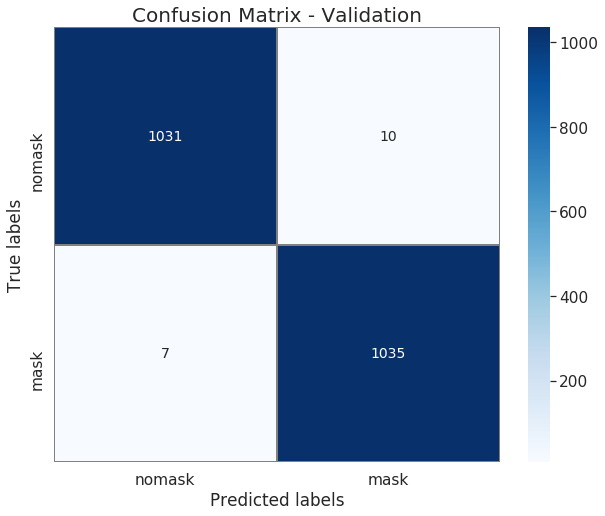

In [31]:
# Plot confusion matrix - validation
cm = confusion_matrix(y_val, val_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Validation')

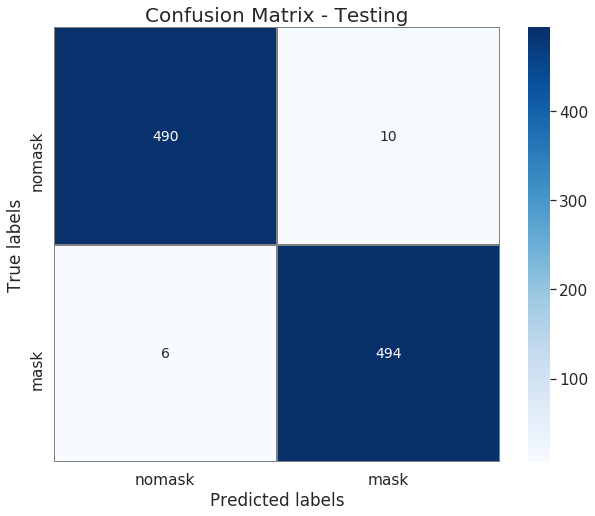

In [32]:
# Plot confusion matrix - test
cm = confusion_matrix(y_test, test_preds)
show_confusion_matrix(cm, 'Confusion Matrix - Testing')

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


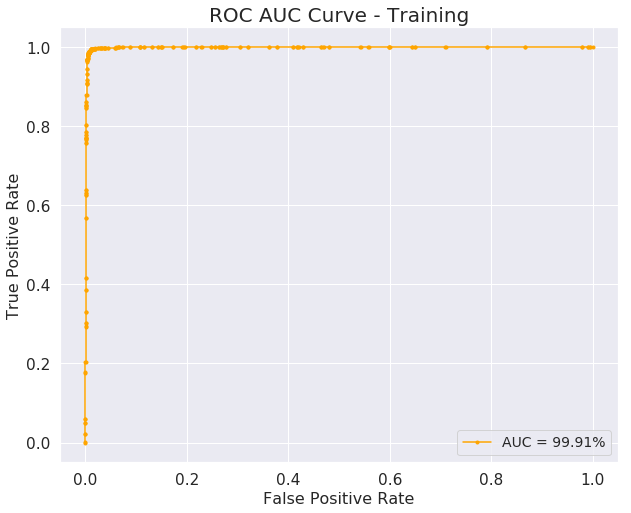

In [33]:
# Predict probability of positive class (nomask) using training (real) images
%time train_preds_proba = svm.predict_proba(train_features)[:,1]
# Plot ROC AUC Curve - Training
svm_fpr, svm_tpr, threshold = roc_curve(y_train, train_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Training')

CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 459 ms


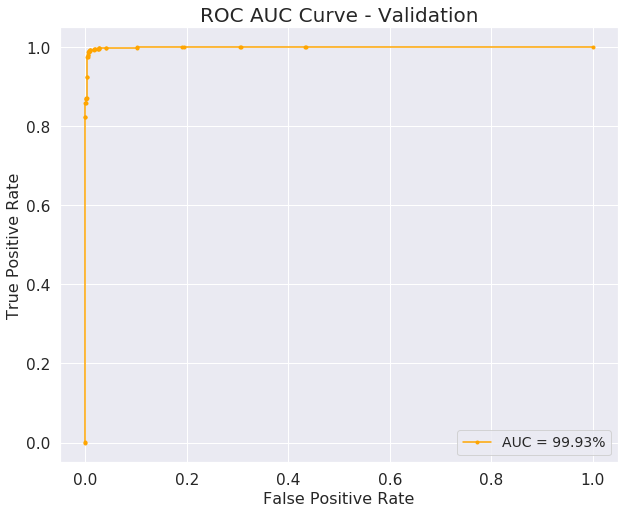

In [34]:
# Predict probability of positive class (nomask) using validation (real) images
%time val_preds_proba = svm.predict_proba(val_features)[:,1]
# Plot ROC AUC Curve - Validation
svm_fpr, svm_tpr, threshold = roc_curve(y_val, val_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Validation')

CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 223 ms


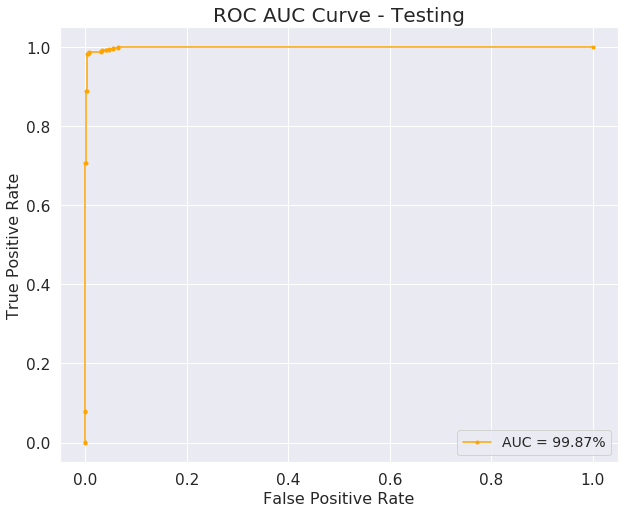

In [35]:
# Predict probability of positive class (nomask) using testing (real) images
%time test_preds_proba = svm.predict_proba(test_features)[:,1]
# Plot ROC AUC Curve - Testing
svm_fpr, svm_tpr, threshold = roc_curve(y_test, test_preds_proba)
auc_svm = auc(svm_fpr, svm_tpr)*100
show_roc_curve(svm_fpr, svm_tpr, auc_svm, 'ROC AUC Curve - Testing')